## Mounting Google Drive


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


##Data Preprocessing for Training and Testing

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import os
import numpy as np

base_dir = r'gdrive/My Drive/face_shape_one'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

rescale_factor = 1./255

train_datagen = ImageDataGenerator(rescale= rescale_factor,
                                  width_shift_range= 40,
                                  height_shift_range= 0.2,
                                  shear_range= 0.2,
                                  zoom_range= 0.2,
                                  horizontal_flip= True,
                                  fill_mode= 'nearest')

test_datagen = ImageDataGenerator(rescale= rescale_factor)

target_width = 150
target_height = 150

train_sample_size = 400
train_batch_size = 20

valid_sample_size = 50
valid_batch_size = 10

test_sample_size = 50
test_batch_size = 10

train_generator = train_datagen.flow_from_directory(
                                directory= train_dir, 
                                target_size= (target_width, target_height),
                                batch_size= train_batch_size, 
                                class_mode= 'categorical')


validation_generator = test_datagen.flow_from_directory(
                                directory= validation_dir, 
                                target_size= (target_width, target_height), 
                                batch_size= valid_batch_size,
                                class_mode= 'categorical')

test_generator = test_datagen.flow_from_directory(
                                directory= test_dir, 
                                target_size= (target_width, target_height), 
                                batch_size= test_batch_size,
                                class_mode= 'categorical')


Using TensorFlow backend.


Found 400 images belonging to 5 classes.
Found 50 images belonging to 5 classes.
Found 50 images belonging to 5 classes.


##Creating the Convolutional base of InceptionV3


In [0]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

conv_base = InceptionV3(
                  weights= 'imagenet',
                  include_top= False,
                  input_shape= (target_width, target_height, 3))


87916544/87910968 [==============================] - 1s 0us/step


##Architecture of Inception V3 Conv Base


In [0]:
conv_base.summary()

##Add a global spatial average pooling layer


In [0]:
x = conv_base.output
x = GlobalAveragePooling2D()(x)

##Adding fully connected layer


In [0]:
x = Dense(1024, activation= 'relu')(x)
predictions = Dense(5, activation= 'softmax')(x)

##Model 

In [0]:
model = Model(inputs= conv_base.input, outputs= predictions)

**Freeze all convolutional layers**

In [0]:
for layer in conv_base.layers:
  layer.trainable = False

**Compile the model**

In [0]:
model.compile(optimizer= 'rmsprop', loss= 'categorical_crossentropy', metrics= ['acc'])

**Training the data**

In [0]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

history = model.fit_generator(
                    generator= train_generator,
                    steps_per_epoch= STEP_SIZE_TRAIN, 
                    epochs= 30, 
                    validation_data= validation_generator, 
                    validation_steps= STEP_SIZE_VALID)

Epoch 1/30
20/20 [==============================] - 52s 3s/step - loss: 2.5414 - acc: 0.2500 - val_loss: 4.7491 - val_acc: 0.2000
Epoch 2/30
20/20 [==============================] - 24s 1s/step - loss: 1.7941 - acc: 0.2825 - val_loss: 2.1556 - val_acc: 0.2600
Epoch 3/30
20/20 [==============================] - 24s 1s/step - loss: 1.6327 - acc: 0.3700 - val_loss: 3.0188 - val_acc: 0.2000
Epoch 4/30
20/20 [==============================] - 24s 1s/step - loss: 1.6293 - acc: 0.3100 - val_loss: 3.1485 - val_acc: 0.2000
Epoch 5/30
20/20 [==============================] - 24s 1s/step - loss: 1.6163 - acc: 0.3700 - val_loss: 1.3894 - val_acc: 0.2800
Epoch 6/30
20/20 [==============================] - 24s 1s/step - loss: 1.5988 - acc: 0.3550 - val_loss: 2.3475 - val_acc: 0.2800
Epoch 7/30
20/20 [==============================] - 29s 1s/step - loss: 1.5337 - acc: 0.3450 - val_loss: 2.0380 - val_acc: 0.3200
Epoch 8/30
20/20 [==============================] - 25s 1s/step - loss: 1.5271 - acc: 0.35

**Plot the results**

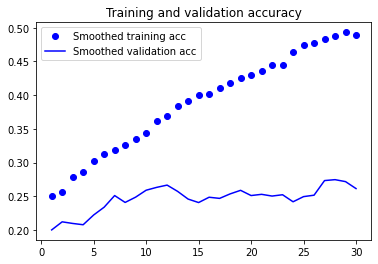

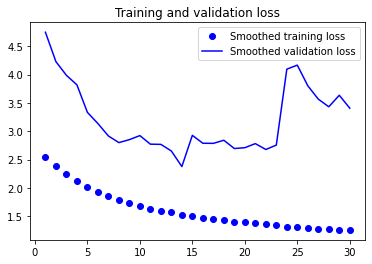

In [0]:
import matplotlib.pyplot as plt

# Plotting the results with smooth curve
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
       
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
           
        else:
            smoothed_points.append(point)
    return smoothed_points

def plot_result(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc)+1)
  plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
  plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
  plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
  plt.title('Training and validation loss') 
  plt.legend()
  plt.show()

plot_result(history)

#Visualing layer names and indicies


In [0]:
for i, layer in enumerate(conv_base.layers):
  print('Layer ', i, ': ', layer.name)

Layer  0 :  input_1
Layer  1 :  conv2d_1
Layer  2 :  batch_normalization_1
Layer  3 :  activation_1
Layer  4 :  conv2d_2
Layer  5 :  batch_normalization_2
Layer  6 :  activation_2
Layer  7 :  conv2d_3
Layer  8 :  batch_normalization_3
Layer  9 :  activation_3
Layer  10 :  max_pooling2d_1
Layer  11 :  conv2d_4
Layer  12 :  batch_normalization_4
Layer  13 :  activation_4
Layer  14 :  conv2d_5
Layer  15 :  batch_normalization_5
Layer  16 :  activation_5
Layer  17 :  max_pooling2d_2
Layer  18 :  conv2d_9
Layer  19 :  batch_normalization_9
Layer  20 :  activation_9
Layer  21 :  conv2d_7
Layer  22 :  conv2d_10
Layer  23 :  batch_normalization_7
Layer  24 :  batch_normalization_10
Layer  25 :  activation_7
Layer  26 :  activation_10
Layer  27 :  average_pooling2d_1
Layer  28 :  conv2d_6
Layer  29 :  conv2d_8
Layer  30 :  conv2d_11
Layer  31 :  conv2d_12
Layer  32 :  batch_normalization_6
Layer  33 :  batch_normalization_8
Layer  34 :  batch_normalization_11
Layer  35 :  batch_normalization_12

***Freeze the 249 layers, which will end up training the last two inception blocks***

In [0]:
for layer in model.layers[:249]:
  layer.trainable = False

for layer in model.layers[249:]:
  layer.trainable = True

##Recompile the model


In [0]:
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr= 0.0001, momentum= 0.9), loss='categorical_crossentropy', metrics= ['acc'])

## Retrain the model again finetuning the last two inception blocks

In [0]:
history = model.fit_generator(
                    generator= train_generator,
                    steps_per_epoch= STEP_SIZE_TRAIN, 
                    epochs= 50, 
                    validation_data= validation_generator, 
                    validation_steps= STEP_SIZE_VALID)

Epoch 1/50
20/20 [==============================] - 41s 2s/step - loss: 1.1560 - acc: 0.5425 - val_loss: 4.2623 - val_acc: 0.2400
Epoch 2/50
20/20 [==============================] - 34s 2s/step - loss: 1.1442 - acc: 0.5725 - val_loss: 2.3416 - val_acc: 0.2600
Epoch 3/50
20/20 [==============================] - 34s 2s/step - loss: 1.0920 - acc: 0.5475 - val_loss: 4.1305 - val_acc: 0.2600
Epoch 4/50
20/20 [==============================] - 35s 2s/step - loss: 1.0745 - acc: 0.5900 - val_loss: 2.4458 - val_acc: 0.2400
Epoch 5/50
20/20 [==============================] - 34s 2s/step - loss: 1.0147 - acc: 0.6175 - val_loss: 3.1832 - val_acc: 0.2400
Epoch 6/50
20/20 [==============================] - 34s 2s/step - loss: 0.9963 - acc: 0.6175 - val_loss: 3.4555 - val_acc: 0.2400
Epoch 7/50
20/20 [==============================] - 34s 2s/step - loss: 1.0260 - acc: 0.5900 - val_loss: 3.4285 - val_acc: 0.2200
Epoch 8/50
20/20 [==============================] - 34s 2s/step - loss: 1.0746 - acc: 0.61

**Plotting the results again**

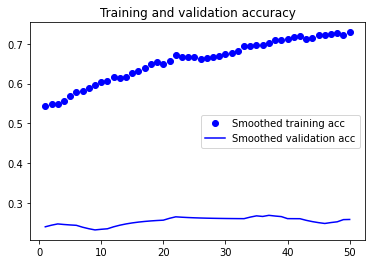

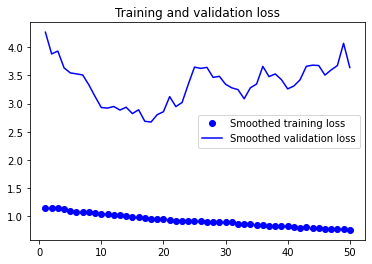

In [0]:
plot_result(history)

##Evaluating the model on test dataset

In [0]:
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

test_loss, test_acc = model.evaluate_generator(test_generator, STEP_SIZE_TEST)

**Accuracy of the model:**

In [0]:
print('Accuracy on the dataset: ', test_acc*100, '%')

Accuracy on the dataset:  34.00000035762787 %
